In [132]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Classifiers:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

Load data, reshape X, and split into training, testing and validation data

In [133]:
y = np.load('MNIST-labels.npy')
X = np.load('MNIST-images.npy')

X = np.where(X<200,0,X) # replace noise in data with 0
X= X.reshape(X.shape[0], 576) #transform to vector
X_train,X_test_val,y_train,y_test_val = train_test_split(X, y, test_size=0.2, random_state = 42)
X_test,X_val,y_test,y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state = 42)

accuracy_df = pd.DataFrame(columns=['Classifier','Accuracy score'])

Function for evaltuating a given classifier. Currently we do this by checking the accuracy score and by plotting the confusion matrix 

In [134]:
def evaluate_classifier(clf,classifier_name):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    accuracy = metrics.accuracy_score(y_val,y_pred)
    
    print("The accuracy score of " + str(classifier_name) + ": " + str(accuracy))
    plt.imshow(metrics.confusion_matrix(y_val,y_pred),cmap='gray')
    plt.title("Confusion matrix for " + str(classifier_name) +"  on validation data")
    current_accuracy_df = {
    'Classifier' : [classifier_name],
    'Accuracy score' : [accuracy]
    }
    current_accuracy_df = pd.DataFrame(current_accuracy_df)
    return current_accuracy_df

Decision tree classifier:

The accuracy score of decision tree classifier gini random: 0.2199812382739212


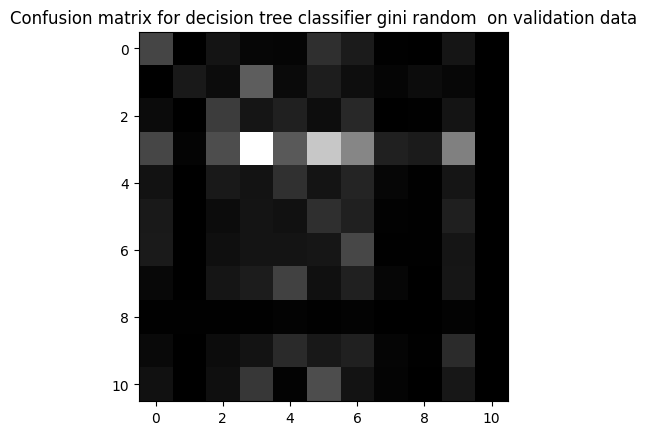

In [135]:
dtc = DecisionTreeClassifier(splitter='random', random_state=1)
dtc_accuracy = evaluate_classifier(dtc,"decision tree classifier gini random")
accuracy_df = pd.concat([accuracy_df, dtc_accuracy])

# dtc = DecisionTreeClassifier(splitter='best', random_state=1)
# dtc_accuracy = evaluate_classifier(dtc,"decision tree classifier gini best")
# accuracy_df = pd.concat([accuracy_df, dtc_accuracy])

# dtc = DecisionTreeClassifier(splitter='random', criterion='entropy', random_state=1)
# dtc_accuracy = evaluate_classifier(dtc,"decision tree classifier entropy random")
# accuracy_df = pd.concat([accuracy_df, dtc_accuracy])

# dtc = DecisionTreeClassifier(splitter='best', criterion='entropy', random_state=1)
# dtc_accuracy = evaluate_classifier(dtc,"decision tree classifier entropy random")
# accuracy_df = pd.concat([accuracy_df, dtc_accuracy])

K nearest neighbors:

The accuracy score of K nearest neighbors 1: 0.9378517823639775
The accuracy score of K nearest neighbors 2: 0.9312851782363978
The accuracy score of K nearest neighbors 3: 0.9412523452157598
The accuracy score of K nearest neighbors 4: 0.9424249530956847
The accuracy score of K nearest neighbors 5: 0.9420731707317073


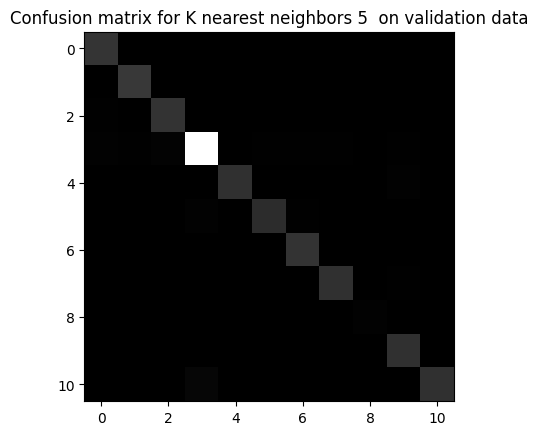

In [138]:
# ks = [1,5,10,15,20,30,50]
ks = [1,2,3,4,5]

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn_accuracy = evaluate_classifier(knn,'K nearest neighbors '+str(k))
    accuracy_df = pd.concat([accuracy_df,knn_accuracy])

In [137]:
accuracy_df#.sort_values(by='accuracy_df')

,Classifier,Accuracy score
0,decision tree classifier gini random,0.219981
0,K nearest neighbors 1,0.937852
0,K nearest neighbors 2,0.931285
0,K nearest neighbors 3,0.941252
